<a href="https://colab.research.google.com/github/safikhanSoofiyani/CS6910-Assignment1/blob/main/CS6910_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing necessary libraries.

In [91]:
import keras
from keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
import copy 
from tqdm import tqdm
import random
import tensorflow as tf

Installing and importing wandb

In [ ]:
!pip install wandb -qqq
import wandb

     |████████████████████████████████| 1.7 MB 5.2 MB/s 
     |████████████████████████████████| 180 kB 64.9 MB/s 
     |████████████████████████████████| 143 kB 68.5 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 


Preparing dataset

In [45]:
from sklearn.model_selection import train_test_split



def prepdata():

  '''This function is used to load the data, define the class labels, performing
      the train-test-validation split, normalizing the data, flattening each data
      point, converting the class labels to one hot encoded vector.

      It return all the split data sets '''


  # Loading data
  (train_x,train_y),(test_x,test_y)=fashion_mnist.load_data()

  # Defining labels for data
  num_classes = 10
  labels=['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

  print("Number of data points in train data (initially) - ", len(train_x))
  print("Number of data points in test data (initially) - ", len(test_x))


  #performing the train-validation split
  train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.1, random_state=40)
  

  print("Shape of each image - 28x28" )
  image_shape=train_x.shape[1]*train_x.shape[2]
  print("shape of each image (1D) - ",image_shape)
  
  train_image_count=len(train_x)
  val_image_count = len(val_x)
  test_image_count=len(test_x)
  
  # Creating a matrix of image data 
  # each image is represented as a row by flattening the matrix: converting (60000,28,28) tensor to (60000,784) matrix
  X_train=np.zeros((train_image_count,image_shape))
  X_val=np.zeros((val_image_count,image_shape))
  X_test=np.zeros((test_image_count,image_shape))
  
  # converting the images into grayscale by normalizing
  for i in range(train_image_count):
    X_train[i]=(copy.deepcopy(train_x[i].flatten()))/255.0 
  for i in range(val_image_count):
    X_val[i]=(copy.deepcopy(val_x[i].flatten()))/255.0
  for i in range(test_image_count):
    X_test[i]=(copy.deepcopy(test_x[i].flatten()))/255.0
  


  #Once hot encoding the label vectors
  y_train = np.zeros((train_y.size, 10))
  y_train[np.arange(train_y.size), train_y] = 1

  y_val = np.zeros((val_y.size, 10))
  y_val[np.arange(val_y.size), val_y] = 1

  y_test = np.zeros((test_y.size, 10))
  y_test[np.arange(test_y.size), test_y] = 1

  

  
  return X_train,X_val,X_test,y_train,y_val,y_test,labels
  

Plotting images locally

Number of data points in train data (initially) -  60000
Number of data points in test data (initially) -  10000
Shape of each image - 28x28
shape of each image (1D) -  784


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


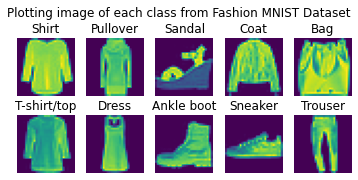

In [46]:
xtrain,xval,xtest,ytrain,yval,ytest,labels=prepdata()
# Creating training dataset
train=np.asarray(list(zip(xtrain,ytrain)))
# plotting a single image from each class
sample_images=[]
wandb_arr=[]
i=1
plt.suptitle("Plotting image of each class from Fashion MNIST Dataset")

while(len(sample_images)!=10):
  n=random.randrange(0,len(train))
  lab_index=np.asarray(np.nonzero(train[n][1]))[0][0]
  
  if(lab_index not in sample_images):
    plt.subplot(3,5,i)
    sample_images.append(lab_index)
    plt.title(labels[lab_index])
    plt.axis(False)
    plt.imshow(train[n][0].reshape((28,28)))
    i=i+1


Plotting images via wandb

In [ ]:
#********** Plotting images via wandb************

# Enter the entity and project details from wandb.ai
wandb.init(entity="",project="")

# Loading dataset
xtrain,xval,xtest,ytrain,yval,ytest,labels=prepdata()

# Creating training dataset
train=np.asarray(list(zip(xtrain,ytrain)))


sample_images=[]
wandb_arr=[]
i=1
plt.suptitle("Plotting image of each class from Fashion MNIST Dataset")
while(len(sample_images)!=10):
  n=random.randrange(0,len(train))
  lab_index=np.asarray(np.nonzero(train[n][1]))[0][0]
  if(lab_index not in sample_images):
    sample_images.append(lab_index)
    wandb_arr.append(wandb.Image(train[n][0].reshape((28,28)),caption=labels[train[n][1]])
    i=i+1
wandb.log({"images":wandb_arr})
wandb.finish()


Implementing Feed Forward Neural Network

In [ ]:
#Separate the functions (to be done later)

In [47]:
def nn_init(layer_sizes,init_type):
  # Layer Sizes denotes the number of neurons per layer
  # 784 is for the input layer. 
  # 32 is for the hidden layers. 
  # 10 is for the output layers

  # initializing parameters for the neural network, 
  params={}
  if(init_type=="xavier"):
    for i in range(1,len(layer_sizes)):
      norm_xav=np.sqrt(6)/np.sqrt(layer_sizes[i]+layer_sizes[i-1])
      params["w"+str(i)]=np.random.randn(layer_sizes[i],layer_sizes[i-1])*norm_xav
      params["b"+str(i)]=np.zeros((layer_sizes[i],1))

  elif(init_type=="random"):
    for i in range(1,len(layer_sizes)):
      params["w"+str(i)]=0.01*np.random.randn(layer_sizes[i],layer_sizes[i-1])
      params["b"+str(i)]=0.01*np.random.randn(layer_sizes[i],1)

  else:
    print("Enter a valid weight initilization type")

  return params


In [48]:
# Activation Functions

def sigmoid(pre_act):
  try:
    return (1.0/(1.0+np.exp(-pre_act)))
  except:
    print("error in sigmoid")

def tanh(pre_act):
  return (np.tanh(pre_act))

def relu(pre_act):
  return (np.maximum(0,pre_act))

def softmax(x):
  try:
    return(np.exp(x)/np.sum(np.exp(x)))
  except:
    print("error in softmax")

In [49]:
def forward_prop(X,y,params,active,layer_sizes):
  
  # Extracting only the image data not the label for the image data
  out=copy.deepcopy(X)
  out=out.reshape(-1,1)
  
  #These are stored just to make it easy to keep track of the indices along with layers.
  h=[out] # To save the activations for each neuron in a layer
  a=[out] # To save the preactivation for each neuron in a layer

  if(active=="sigmoid"):
    for i in range(1,len(layer_sizes)-1):
      weights=params["w"+str(i)]
      biases=params["b"+str(i)]
      
      out=np.dot(weights,h[i-1])+biases
      a.append(out)
      post_a=sigmoid(out)
      h.append(post_a)
  
  elif(active=="tanh"):
    for i in range(1,len(layer_sizes)-1):
      weights=params["w"+str(i)]
      biases=params["b"+str(i)]
      
      out=np.dot(weights,h[i-1])+biases
      a.append(out)
      post_a=tanh(out)
      h.append(post_a)
  
  elif(active=="relu"):
    for i in range(1,len(layer_sizes)-1):
      weights=params["w"+str(i)]
      biases=params["b"+str(i)]
      
      out=np.dot(weights,h[i-1])+biases
      a.append(out)
      post_a=relu(out)
      h.append(post_a)       
  else:
    print("Enter a valid activation function") 

  # Final step for forward propagation, using softmax.
  weights=params["w"+str(len(layer_sizes)-1)]
  biases=params["b"+str(len(layer_sizes)-1)]
  
  out=np.dot(weights,h[len(layer_sizes)-2])+biases
  a.append(out)
  y_hat=softmax(out)
  h.append(y_hat)
  
  
  #in h we  are storing values for layers right from input till output
  #h0 is input
  #in a we are storing values for layers right from input till output
  #a0 is input

  return h,a,y_hat

In [93]:

# Calculating loss 
def loss_calc(name,y_t,y_hat):
  error=0
  if(name=="sse"):
    error=np.sum(((y_t-y_hat)**2)/(2*len(y_t)))
  elif(name=="cross_entropy"):
    error=-np.sum(np.multiply(y_t,np.log(y_hat)))/len(y_t)
    #error = -np.sum(np.sum(y_t*np.log(y_hat)))

  return error


In [54]:
# Calculating derivatives of the acitvation functions
def derivative(A, activation):
  if activation == "sigmoid":
    return sigmoid_der(A)
  elif activation == "tanh":
    return tanh_der(A)
  elif activation == "relu":
    return relu_der(A)


def sigmoid_der(x):
  return sigmoid(x)*(1-sigmoid(x))

def tanh_der(x):
  return 1.0 -tanh(x)**2

def relu_der(x):
  return 1. * (x>0)


In [83]:
def back_prop(y, y_hat, h, a, params, loss_type, layer_sizes, activation):
  
  #here both y_hat and y are assumed to be column vectors



  grad = {}

  if loss_type == "squared_error":
    #waiting
    k = 0

  elif loss_type == 'cross_entropy':
    #Here actually it should be one hot vector. But y does the same job
    grad["da"+str(len(layer_sizes)-1)] = -(y-y_hat)
    grad["dh"+str(len(layer_sizes)-1)] = -(y/y_hat)

  for i in range(len(layer_sizes)-1, 0, -1 ):
    #print(i)
    grad["dw"+str(i)] = np.dot(grad["da"+str(i)], np.transpose(h[i-1]))
    grad["db"+str(i)] = grad["da"+str(i)]

    if i > 1:
      grad["dh"+str(i-1)] = np.dot(np.transpose(params["w"+str(i)]), grad["da"+str(i)])
      grad["da"+str(i-1)] = np.multiply(grad["dh" + str(i-1)], derivative(a[i-1],activation))
 
  return grad



In [119]:
def mini_batch_gd(X_train,y_train):
  parameters = nn_init([784,32,32,10], 'random')
  eta = 0.0001
  max_epochs = 5
  layers = [784,32,32,10]
  grads={}
  err_list = []
  mini_batch_size = 32

  #iterate till max epochs
  for t in tqdm(range(max_epochs)):

    

    #iterate over all batches
    for i in range(0, len(X_train), mini_batch_size):

      grads.clear()

      X = X_train[i:i + mini_batch_size]
      Y = y_train[i:i + mini_batch_size]
      
      #iterate over all the points in the current batch
      for j in range(len(X)):

        y = np.reshape(Y[j], (-1,1))

        #Feed forward the data point
        h,a,y_hat = forward_prop(X[j], y, parameters, "sigmoid", layers)

        #backpropagate the error.
        new_grads = back_prop(y,y_hat, h,a, parameters, "cross_entropy", layers, "sigmoid")

        #keep collecting the gradients for all the data (since vanilla GD)
        if j == 0:
          grads = copy.deepcopy(new_grads)
        else:
          #adding the gradients
          for k in range(len(layers)-1,0,-1):
            grads["dw"+str(k)] += new_grads["dw"+str(k)]
            grads["db"+str(k)] += new_grads["db"+str(k)]
            #grads["da"+str(i)] += new_grads["da"+str(i)]
            #grads["dh"+str(i)] += new_grads["dh"+str(i)]
        
    
      #Updating the parameters once every one epoch
      for j in range(len(layers)-1,0,-1):
        parameters["w"+str(j)] = parameters["w"+str(j)] - (eta * grads["dw"+str(j)])
        parameters["b"+str(j)] = parameters["b"+str(j)] - (eta * grads["db"+str(j)])

    res = predict(X_train,y_train,parameters, "sigmoid", [784,32,32,10])
    err = loss_calc("cross_entropy", y_train,res)
    err_list.append(err)

  return parameters, err_list

In [120]:
def predict(X_train,y_train,parameters,active,layer_sizes):

  '''This function is used to simple take a model parameters
      and run the data points using forward prop, and return the outputs 
      of all the input data points'''

  result = []

  for i in range(len(X_train)):
    h,a,y_hat = forward_prop(X_train[i], y_train[i], parameters, active, layer_sizes)

    #converting y_hat to a 1d array to match with the y
    y_hat = y_hat.flatten()
    result.append(y_hat)
  
  return result


In [121]:
X_train,X_val,X_test,y_train,y_val,y_test,labels = prepdata()
params , err_list = vanilla_gd(X_train,y_train)
print(err_list)

res = predict(X_train,y_train,params, "sigmoid", [784,32,32,10])



err = loss_calc("cross_entropy", y_train,res)


#print(err)

Number of data points in train data (initially) -  60000
Number of data points in test data (initially) -  10000
Shape of each image - 28x28
shape of each image (1D) -  784


100%|██████████| 5/5 [01:50<00:00, 22.11s/it]


[1.9823762725236518, 1.6964494648321886, 1.473479254787757, 1.3110634977524744, 1.1892397949188154]
